Sayısal sütunlar: Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'BarajDoluluk', 'dakika'],
      dtype='object')


<ipython-input-15-bb2f29f03666>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 1/3, Train Loss: 0.00012663354772047132, Test Loss: 0.001634516153222801
Train MSE: 0.00012721678372167608, Test MSE: 0.0016987534146978833
Train MAPE: 114.50247764587402%, Test MAPE: inf%
Train MAE: 0.008619496966278799, Test MAE: 0.005685210016627724
Train RMSE: 0.011279041790935793, Test RMSE: 0.04121593641660812
Train R²: -2.3096221613264656, Test R²: -0.001080586208325185
Training Time: 74.72598576545715 seconds, Inference Time: 4.881891489028931 seconds


<ipython-input-15-bb2f29f03666>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 2/3, Train Loss: 7.179585697856426e-05, Test Loss: 0.0016344353990681863
Train MSE: 7.198698753892105e-05, Test MSE: 0.001698672463399205
Train MAPE: 90.23012518882751%, Test MAPE: inf%
Train MAE: 0.006579222278099099, Test MAE: 0.005529316424384203
Train RMSE: 0.008484514572968865, Test RMSE: 0.04121495436609393
Train R²: -0.8727853535991461, Test R²: -0.001032881360267801
Training Time: 76.05679869651794 seconds, Inference Time: 2.9482312202453613 seconds


<ipython-input-15-bb2f29f03666>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 3/3, Train Loss: 6.601453351659411e-05, Test Loss: 0.0016406777188625423
Train MSE: 6.634044340623383e-05, Test MSE: 0.0017046306045261162
Train MAPE: 79.65952157974243%, Test MAPE: inf%
Train MAE: 0.006165308568848689, Test MAE: 0.006651435560411495
Train RMSE: 0.008144964297419224, Test RMSE: 0.04128717239683672
Train R²: -0.7258870666770774, Test R²: -0.004544032160868738
Training Time: 76.05733323097229 seconds, Inference Time: 2.9001288414001465 seconds


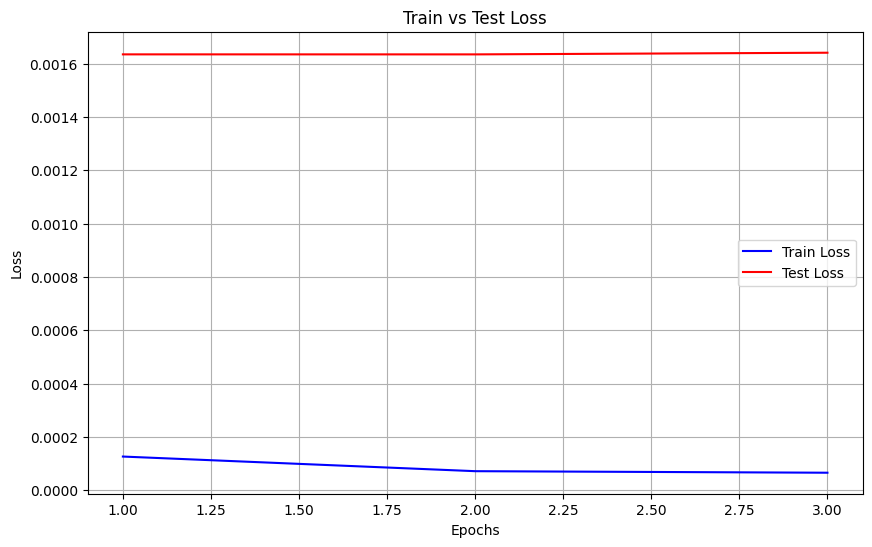

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # Eğitim ve çıkarım sürelerini takip etmek için ekledim

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "sazlıderekullan.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "BarajDoluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("BarajDoluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Temporal Fusion Transformer (TFT) Modeli
class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output

# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 96  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 3  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("pabuçdereveriler.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()
